In [18]:
import xarray as xr
import numpy as np
import netCDF4 as nc
from metpy import calc
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
wrf=xr.open_dataset('./wrfout_d01_2017-05-16_22_00_00')
zdrfile= xr.open_dataset('./zdr_after_101.nc')

In [8]:
'''calculate temperature C from perturbed potential temperature (K)'''
rp0 = 1.E-5   # p0=100000 的倒数
Rd = 287.04
Cp = 7.*Rd/2.
RCP = Rd/Cp
##
qv3d=wrf['QVAPOR'][0,:,:,:]
TEMP=wrf['T'][0,:,:,:]
Pres=wrf['P'][0,:,:,:]+wrf['PB'][0,:,:,:]
T= (TEMP + 300.) * ( Pres * rp0 )**RCP # get the temperature (K) of from WRF TEMP(perturbed potential temperature)
print('qv3d coords: {}, \n qv3d attrs: {}'.format(qv3d.coords,qv3d.attrs['units']))
qv3d.attrs['units']='dimensionless'
T.attrs={"units":'K'}
Pres.attrs={"units":'Pa'}
Pres.assign_attrs({"units": 'pressure'})
print(qv3d.attrs['units'],T.attrs,Pres.attrs)
rh=calc.relative_humidity_from_mixing_ratio(qv3d,T,Pres) # calculate relative humidity & transfer to 1D array

qv3d coords: Coordinates:
    XLAT     (south_north, west_east) float32 ...
    XLONG    (south_north, west_east) float32 ...
    XTIME    datetime64[ns] ..., 
 qv3d attrs: kg kg-1
dimensionless {'units': 'K'} {'units': 'Pa'}


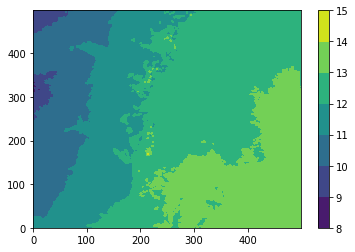

In [97]:
#zews =np.where( T <= -1, 0.0, a2 * (rho * snow)**1.75)
#df['ZDRCol_Exist']=df['ZDR'].apply(lambda x:int(x>1)) & df['Temp'].apply(lambda x: int(x<273.55))
rh.shape
melting_height=np.zeros((500,500),int)
def find_nearest(array):
    value=273.15
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
for i in np.arange(0,500):
    for j in np.arange(0,500):
        melting_height[j,i]=find_nearest(T[:,j,i])


#melting_height=map(find_nearest,T[:,j,i] for j in np.arange(0,500) for i in np.arange(0,500))
#melting_height.shape
plt.contourf(melting_height)
plt.colorbar()

In [100]:
rh=np.where(rh > 1.05, 1.05, rh)
#index=np.max(rh[11:15,:,:],axis=0)>=1
rh_profile=[]
for i in np.arange(0,500):
    for j in np.arange(0,500):
        melting_height[j,i]=find_nearest(T[:,j,i])
        if np.max(rh[melting_height[j,i]:melting_height[j,i]+10,j,i])>=1:
            rh_profile=np.append(rh_profile,rh[melting_height[j,i]:melting_height[j,i]+20,j,i],axis=0)
#index2=np.max(rh[12:,:,:],axis=0)>=1.05
#plt.contour(index2)
rh_profile.shape

(33720,)

In [102]:
np.unique(index,return_counts=True)

(array([False,  True]), array([247967,   2033], dtype=int64))

In [104]:
np.reshape(rh_profile,(20,1686))

array([[0.55731803, 0.71281928, 0.97351015, ..., 0.55042624, 0.58940256,
        0.72306931],
       [0.86888278, 0.96259481, 0.9905557 , ..., 1.04999995, 0.91073233,
        0.67969465],
       [0.40710768, 0.11038039, 0.        , ..., 0.06753171, 0.04831313,
        0.04151349],
       ...,
       [0.76218063, 0.83978963, 0.83621502, ..., 0.74282581, 0.64892691,
        0.6471982 ],
       [0.64458156, 0.63147742, 0.61303872, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.31659576, 0.27017507, ..., 0.66067839, 0.58458793,
        0.57309699]]) <Unit('dimensionless')>

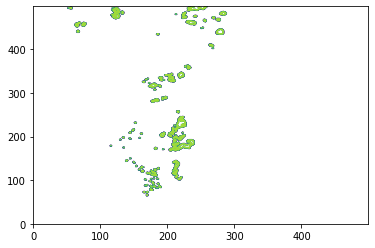

In [73]:
plt.contour(index)

In [74]:
mask3d=np.broadcast_to(index,rh.shape)

#plt.contour(mask3d[10,:,:])

In [75]:
rh_mask=np.ma.masked_array(data=rh,mask=~mask3d)

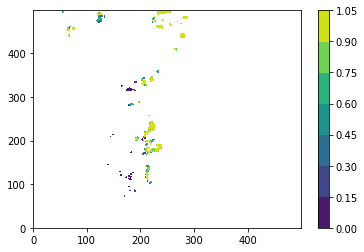

In [78]:
plt.contourf(rh_mask[15,:,:])
plt.colorbar()

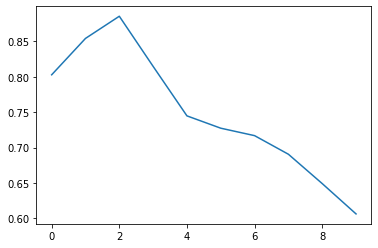

In [84]:
rh_get=np.average(rh_mask[10:20],axis=(1,2))
plt.plot(rh_get)

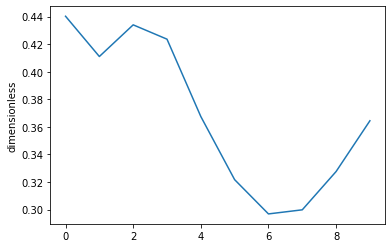

In [85]:
rh_get=np.average(rh[10:20],axis=(1,2))
plt.plot(rh_get)

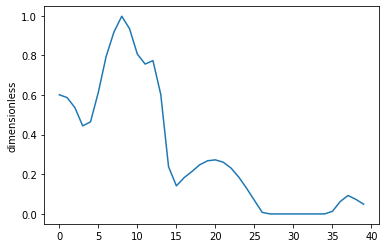

In [48]:
plt.plot(rh[:,200,200])